# Homework 5

## Exercise 1: Correlations
Let's recreate the plot from the lecture. Assume two neurons that are tuned to a directed stimulus $s\in[0, 2\pi]$. The neurons are Poisson neurons with rates (in Hz)
\begin{align}
r_1(s) &= \exp\left(\sin(s - \frac{\pi}{4})\right) \\
r_2(s) &= \exp\left(\sin\left(s - \frac{\pi}{2}\right)\right)
\end{align}

a) Draw 10,000 stimuli uniformly. For both neurons, draw spike counts for a measurement duration of 25 seconds and save the firing rates. Discretize the range for the stimuli into 20 bins and compute the tuning curves (average firing rate). Plot the tuning curves for both neurons into separate subplots. Additionally, pick one bin and plot all firing rates for that bin as a scatter plot (for each neuron, plot into the same corresponding subplot). (3 points)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%load_ext jupyter_black

# set seed for reproducibility
np.random.seed(42)

# Constants
n_samples = 10000
T = 25  # measurement duration
n_bins = 20

# Generate stimuli
s = np.random.uniform(0, 2 * np.pi, n_samples)

# Compute firing rates
r1 = np.exp(np.sin(s - (np.pi / 4)))
r2 = np.exp(np.sin(s - (np.pi / 2)))

# Simulate spike counts
spike_counts_1 = np.random.poisson(r1 * T)
spike_counts_2 = np.random.poisson(r2 * T)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [13]:
# Bin stimuli
bins = np.linspace(0, 2 * np.pi, n_bins + 1)
bin_indices = np.digitize(s, bins) - 1  # Bin index per stimulus

In [14]:
# Compute tuning curves
tuning_curve_1 = np.array(
    [np.mean(spike_counts_1[bin_indices == i]) / T for i in range(n_bins)]
)
tuning_curve_2 = np.array(
    [np.mean(spike_counts_2[bin_indices == i]) / T for i in range(n_bins)]
)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

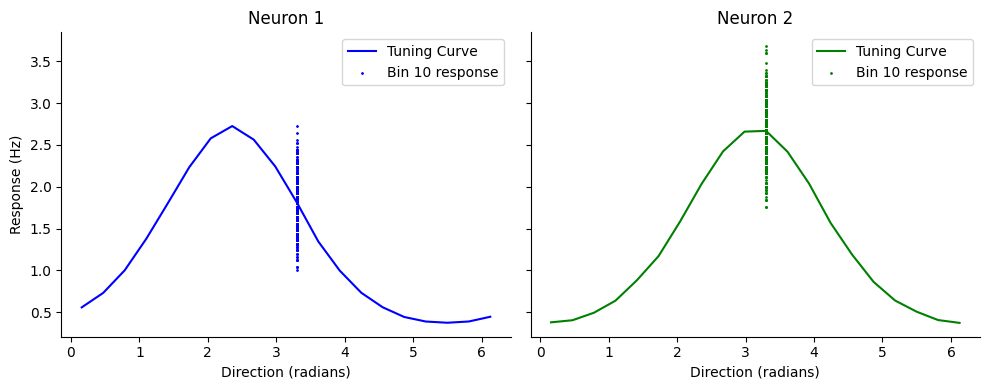

In [15]:
# Plot tuning curves
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(bin_centers, tuning_curve_1, label="Tuning Curve", color="blue")
axs[0].set_title("Neuron 1")
axs[0].set_ylabel("Response (Hz)")
axs[0].set_xlabel("Direction (radians)")

axs[1].plot(bin_centers, tuning_curve_2, label="Tuning Curve", color="green")
axs[1].set_title("Neuron 2")
axs[1].set_xlabel("Direction (radians)")

# Pick one bin for scatter plot (e.g., bin 10)
selected_bin = 10
mask = bin_indices == selected_bin

sc_bin_1 = spike_counts_1[mask] / T
sc_bin_2 = spike_counts_2[mask] / T

axs[0].scatter(
    bin_centers[selected_bin] * np.ones(np.sum(mask)),
    sc_bin_1,
    s=1,
    color="blue",
    label="Bin 10 response",
)
axs[1].scatter(
    bin_centers[selected_bin] * np.ones(np.sum(mask)),
    sc_bin_2,
    s=1,
    color="green",
    label="Bin 10 response",
)

for i in range(2):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].legend()

plt.tight_layout()
plt.show()


b) For this one bin, scatter plot the firing rates. Compute and plot the noise correlation. (1 point)


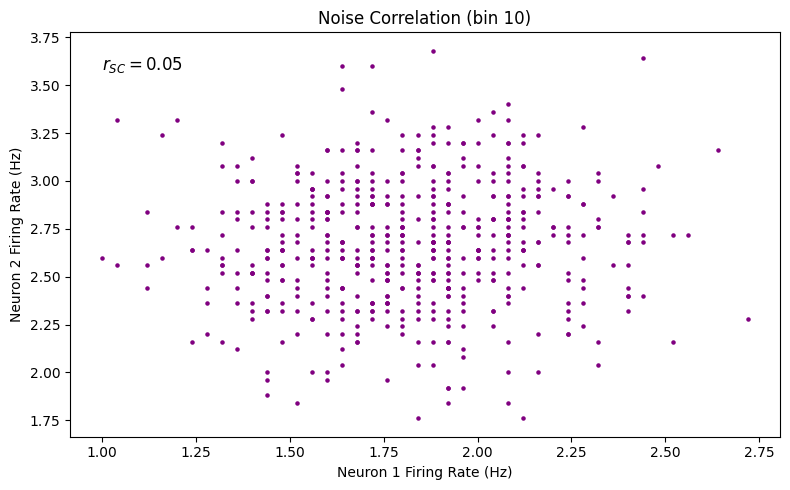

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(sc_bin_1, sc_bin_2, s=5, color="purple")
plt.xlabel("Neuron 1 Firing Rate (Hz)")
plt.ylabel("Neuron 2 Firing Rate (Hz)")
plt.title("Noise Correlation (bin 10)")
r_noise, _ = pearsonr(sc_bin_1, sc_bin_2)  # Noise correlation
plt.text(
    min(sc_bin_1), max(sc_bin_2) - 0.1, rf"$r_{{SC}} = {r_noise:.2f}$", fontsize=12
)
plt.tight_layout()
plt.show()

c) Scatter plot the simulated tuning curves. Compute and plot the signal correlation. (1 point)

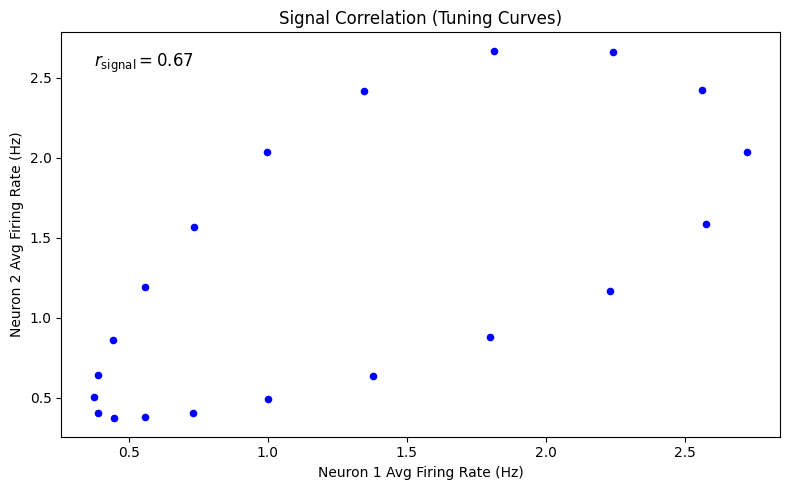

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(tuning_curve_1, tuning_curve_2, s=20, color="blue", marker="o")
plt.xlabel("Neuron 1 Avg Firing Rate (Hz)")
plt.ylabel("Neuron 2 Avg Firing Rate (Hz)")
plt.title("Signal Correlation (Tuning Curves)")
r_signal, _ = pearsonr(tuning_curve_1, tuning_curve_2)  # Signal correlation
plt.text(
    min(tuning_curve_1),
    max(tuning_curve_2) - 0.1,
    rf"$r_{{\text{{signal}}}} = {r_signal:.2f}$",
    fontsize=12,
)
plt.tight_layout()
plt.show()

d) Confirm the law of total covariance by computing all of its components (2x2 matrices). (1 point)

In [18]:
# Total covariance (over all trials)
data_all = np.vstack([spike_counts_1 / T, spike_counts_2 / T])
total_cov = np.cov(data_all)
print("Total covariance:\n", total_cov)

# Noise covariance (average of within-bin covariances)
noise_covs = []
for i in range(n_bins):
    mask = bin_indices == i
    if np.sum(mask) > 1:  # at least 2 samples to compute covariance
        bin_data = np.vstack([spike_counts_1[mask] / T, spike_counts_2[mask] / T])
        cov_bin = np.cov(bin_data)
        noise_covs.append(cov_bin)

mean_noise_cov = np.mean(noise_covs, axis=0)
print("Mean noise covariance:\n", mean_noise_cov)

# Signal covariance (covariance of tuning curves)
tuning_data = np.vstack([tuning_curve_1, tuning_curve_2])
signal_cov = np.cov(tuning_data)
print("Signal covariance:\n", signal_cov)

# Check if total ≈ noise + signal
sum_cov = mean_noise_cov + signal_cov
print("Sum of noise + signal covariance:\n", sum_cov)

# difference for numerical confirmation
print("Difference (total - sum):\n", total_cov - sum_cov)

Total covariance:
 [[0.72787736 0.45231493]
 [0.45231493 0.73007749]]
Mean noise covariance:
 [[0.05645878 0.00485161]
 [0.00485161 0.05822385]]
Signal covariance:
 [[0.70660295 0.46909661]
 [0.46909661 0.69959696]]
Sum of noise + signal covariance:
 [[0.76306172 0.47394822]
 [0.47394822 0.75782081]]
Difference (total - sum):
 [[-0.03518436 -0.02163329]
 [-0.02163329 -0.02774331]]


Since the difference matrix has small elements, the law of total covariance is confirmed.

e) Now, we conduct a different experiment with only 2 stimuli: $s_1 = \frac\pi4$ and $s_2=\frac{\pi}{2}$. Draw 1000 stimuli each and create a scatter plot of the firing rate responses. In the same plot, for each neuron illustrate the covariance (with an ellipse) and the decision boundary (as a line). (2 points)

In [19]:
# Constants
n_trials = 1000
s1, s2 = np.pi / 4, np.pi / 2

# Compute firing rates
r1_s1 = np.exp(np.sin(s1 - np.pi / 4))
r2_s1 = np.exp(np.sin(s1 - np.pi / 2))
r1_s2 = np.exp(np.sin(s2 - np.pi / 4))
r2_s2 = np.exp(np.sin(s2 - np.pi / 2))

# Simulate spike counts
sc1 = np.random.poisson(r1_s1 * T, n_trials)
sc2 = np.random.poisson(r2_s1 * T, n_trials)
sc3 = np.random.poisson(r1_s2 * T, n_trials)
sc4 = np.random.poisson(r2_s2 * T, n_trials)

# Convert to firing rates
fr_s1 = np.vstack([sc1 / T, sc2 / T]).T
fr_s2 = np.vstack([sc3 / T, sc4 / T]).T

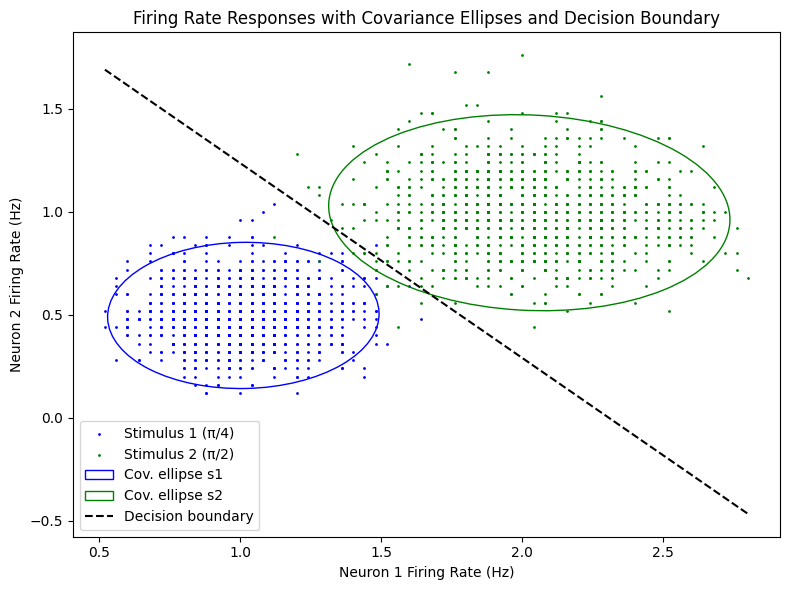

In [20]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(fr_s1[:, 0], fr_s1[:, 1], s=1, label="Stimulus 1 (π/4)", color="blue")
plt.scatter(fr_s2[:, 0], fr_s2[:, 1], s=1, label="Stimulus 2 (π/2)", color="green")


# Covariance ellipses
def plot_cov_ellipse(data, ax, color, label=None):
    cov = np.cov(data.T, bias=False)
    mean = np.mean(data, axis=0)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    scale = np.sqrt(5.991)  # 95% confidence interval for 2D Gaussian
    width, height = 2 * scale * np.sqrt(vals)
    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=theta,
        edgecolor=color,
        fc="None",
        lw=1,
        label=label,
    )
    ax.add_patch(ellipse)


ax = plt.gca()
plot_cov_ellipse(fr_s1, ax, color="blue", label="Cov. ellipse s1")
plot_cov_ellipse(fr_s2, ax, color="green", label="Cov. ellipse s2")

# Decision boundary using LDA
X = np.vstack([fr_s1, fr_s2])
y = np.array([0] * n_trials + [1] * n_trials)
clf = LDA()
clf.fit(X, y)
# Create line
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
slope = -clf.coef_[0, 0] / clf.coef_[0, 1]
intercept = -clf.intercept_[0] / clf.coef_[0, 1]
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, "k--", label="Decision boundary")

plt.xlabel("Neuron 1 Firing Rate (Hz)")
plt.ylabel("Neuron 2 Firing Rate (Hz)")
plt.legend()
plt.title("Firing Rate Responses with Covariance Ellipses and Decision Boundary")
plt.tight_layout()
plt.show()

f) Brainstorm at least three biologically plausible ways how noise covariances could appear in our measurements. Discuss whether they can be positive or negative. (1,5 points)

*Hint: You are allowed and encouraged to use the forum for an open exchange among students for this.*


1. **Shared Synaptic Input**: Neurons often receive synaptic inputs from a common source. When two neurons share this input, their firing rates could fluctuate in tandem, as the upstream activity simultaneously modulates their responses. For example, an excitatory common input increases the likelihood that both downstream neurons fire together on a given trial. This coordinated activity results in positive noise covariance, as the neurons’ responses co-vary in the same direction due to the shared drive. One reason might be additional computations performed by both neurons that are not captured by the experimental setup (such as the variables tracked, e.g. stimulus angle) and thus registered as noise to us.

2. **Global Brain State Fluctuations**: Neural activity is influenced by global brain states, such as variations in arousal, attention, or neuromodulatory tone, mediated by neurotransmitters. These slow fluctuations can cause widespread changes in excitability across neural populations, leading to correlated variability. For instance, heightened arousal may increase the firing rates of many neurons simultaneously, producing positive noise covariance. However, if certain neurons exhibit differential sensitivity to these states (e.g., one neuron is excited while another is suppressed by a neuromodulator), negative covariance may occur.

3. **Local Circuit Interactions**: Local neural circuits, involving excitatory and inhibitory interneurons, introduce structured variability that can generate noise covariances. For example, if two excitatory neurons are modulated by the same inhibitory interneuron, increased activity in one neuron may enhance inhibition, suppressing the other, leading to negative covariance due to competitive dynamics. Alternatively, shared inhibition affecting both neurons simultaneously can reduce their activity together, resulting in positive covariance.

g) Choose one model that allows for positive and (!) negative noise correlations and implement it. Repeat the plot from e) with positive and negative noise correlations (two subplots). Discuss and compute (with MDE) whether the noise correlations support or obstruct decoding. (4 points)

We implement a bivariate Gaussian model of firing rates with the same mean rates (from Poisson simulations in (e)) and manually defined noise covariance matrices, one with positive and one with negative correlation. We also make sure to sample non-negative firing rates from the Gaussian model.

This allows us to control the sign and strength of the noise correlations, which Poisson models don’t natively allow.

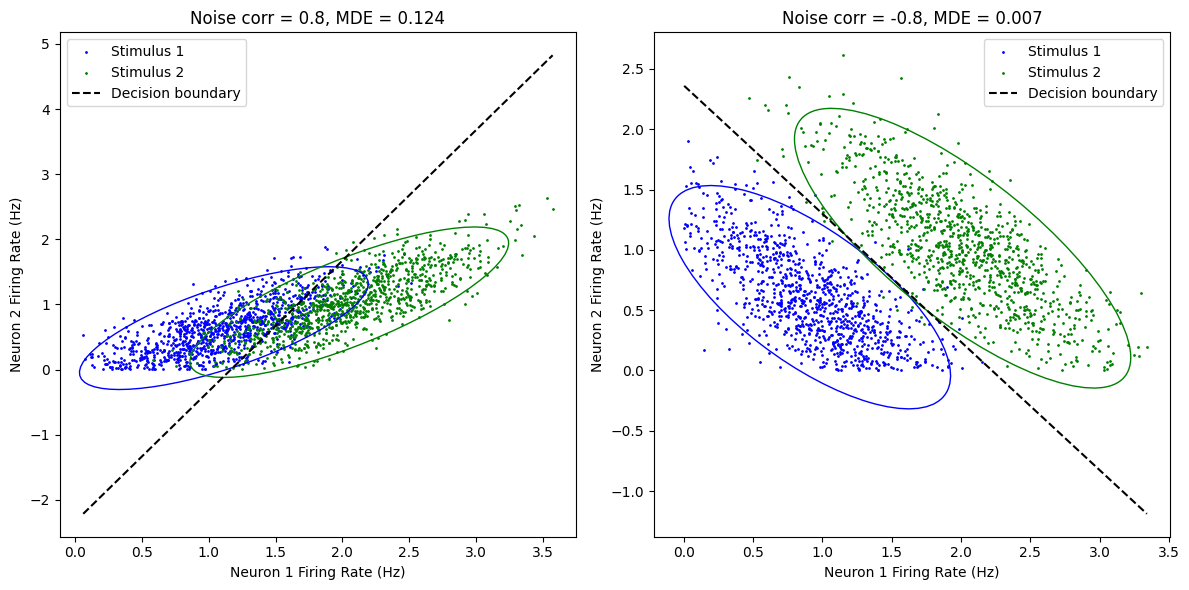

In [35]:
# Mean firing rates for each stimulus
mu1 = np.array([np.exp(np.sin(s1 - np.pi / 4)), np.exp(np.sin(s1 - np.pi / 2))])
mu2 = np.array([np.exp(np.sin(s2 - np.pi / 4)), np.exp(np.sin(s2 - np.pi / 2))])

stds = np.array([0.5, 0.5])  # arbitrary variability


def compute_mde(mu1, mu2, cov, n_grid=200):
    """
    Compute Minimal Discriminant Error using Monte Carlo integration.
    """
    # Create a grid in 2D space to sample the posterior densities
    x = np.linspace(min(mu1[0], mu2[0]) - 3, max(mu1[0], mu2[0]) + 3, n_grid)
    y = np.linspace(min(mu1[1], mu2[1]) - 3, max(mu1[1], mu2[1]) + 3, n_grid)
    X, Y = np.meshgrid(x, y)
    grid = np.column_stack([X.ravel(), Y.ravel()])

    # Evaluate both posterior densities
    priors = np.array([0.5, 0.5])  # equal priors for both stimuli
    p1 = multivariate_normal.pdf(grid, mean=mu1, cov=cov) * priors[0]
    p2 = multivariate_normal.pdf(grid, mean=mu2, cov=cov) * priors[1]

    # Find the minimum of the two densities at each point
    min_p = np.minimum(p1, p2)

    # Compute the area under the minimum density using trapezoidal integration
    area = np.trapezoid(
        np.trapezoid(min_p.reshape(n_grid, n_grid), y), x
    )  # double integral

    return area  # MDE


def drop_negative_samples(mu, cov, n_samples):
    samples = []
    while len(samples) < n_samples:
        draw = np.random.multivariate_normal(mu, cov)
        if np.all(draw >= 0):
            samples.append(draw)
    return np.array(samples)


# Simulate and plot for both rho = +0.8 and -0.8

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, rho in enumerate([0.8, -0.8]):

    cov_matrix = np.array(
        [
            [stds[0] ** 2, rho * stds[0] * stds[1]],
            [rho * stds[0] * stds[1], stds[1] ** 2],
        ]
    )

    mde = compute_mde(mu1, mu2, cov_matrix)

    # fr1 = np.random.multivariate_normal(mu1, cov_matrix, n_trials)
    # fr2 = np.random.multivariate_normal(mu2, cov_matrix, n_trials)
    fr1 = drop_negative_samples(mu1, cov_matrix, n_trials)
    fr2 = drop_negative_samples(mu2, cov_matrix, n_trials)

    X = np.vstack([fr1, fr2])
    y = np.array([0] * n_trials + [1] * n_trials)
    clf = LDA()
    clf.fit(X, y)

    axs[i].scatter(fr1[:, 0], fr1[:, 1], s=1, label="Stimulus 1", color="blue")
    axs[i].scatter(fr2[:, 0], fr2[:, 1], s=1, label="Stimulus 2", color="green")
    plot_cov_ellipse(fr1, axs[i], "blue")
    plot_cov_ellipse(fr2, axs[i], "green")

    # Decision boundary
    slope = -clf.coef_[0, 0] / clf.coef_[0, 1]
    intercept = -clf.intercept_[0] / clf.coef_[0, 1]
    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_vals = slope * x_vals + intercept
    axs[i].plot(x_vals, y_vals, "k--", label="Decision boundary")

    axs[i].set_title(f"Noise corr = {rho:.1f}, MDE = {mde:.3f}")
    axs[i].set_xlabel("Neuron 1 Firing Rate (Hz)")
    axs[i].set_ylabel("Neuron 2 Firing Rate (Hz)")
    axs[i].legend()

plt.tight_layout()
plt.show()

In the case of positive noise correlation, we observe that the scatter plots for each stimulus is highly overlapped causing a higher MDE, and thus obstructs decoding.

While with negative noise correlation, we observe that the scatter plots for each stimulus are better seperable causing a lower MDE, and thus supporting better decoding.

We observe that since there is positive signal correlation, having positive noise correlation would obstruct decoding and vice-versa in the case of negative noise correlaton. Thus, it can be deduced that having noise correlations aligned with signal correlation would obstruct decoding, while having orthogonal noise correlations to signal correlation would support decoding.

h) Repeat g) for a different set of stimuli that have the opposite (inversed sign) signal correlation. (1 point)

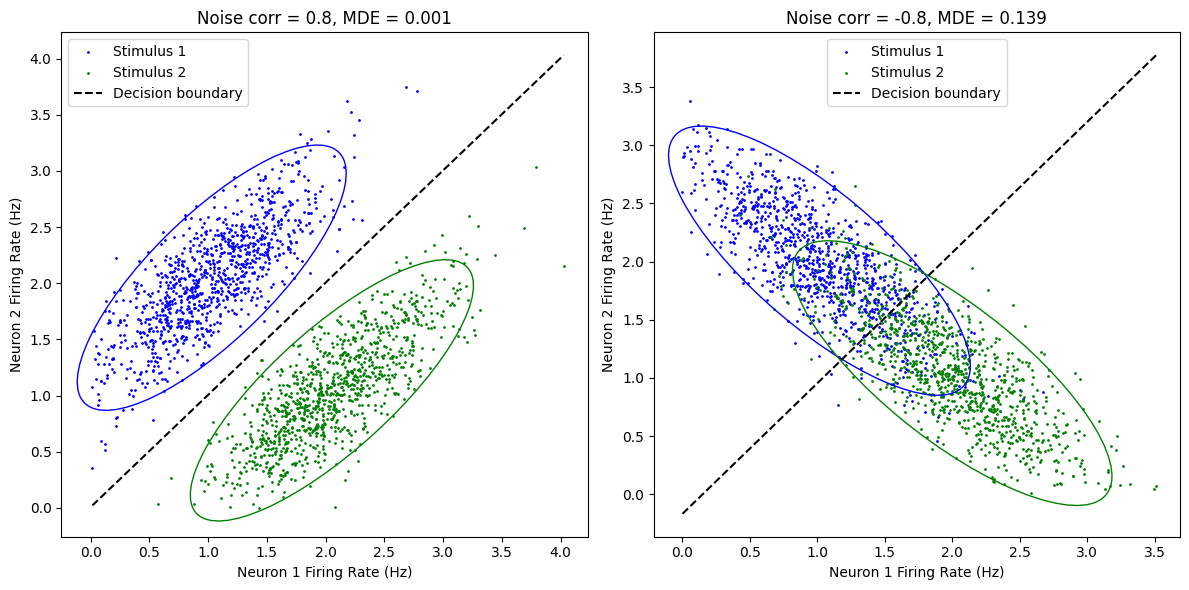

In [37]:
# Mean firing rates for each stimulus
mu1 = np.array([np.exp(np.sin(s1 - np.pi / 4)), np.exp(np.sin(s1 + np.pi / 2))])
mu2 = np.array([np.exp(np.sin(s2 - np.pi / 4)), np.exp(np.sin(s2 + np.pi / 2))])

stds = np.array([0.5, 0.5])  # arbitrary variability


# Simulate and plot for both rho = +0.8 and -0.8

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, rho in enumerate([0.8, -0.8]):

    cov_matrix = np.array(
        [
            [stds[0] ** 2, rho * stds[0] * stds[1]],
            [rho * stds[0] * stds[1], stds[1] ** 2],
        ]
    )

    mde = compute_mde(mu1, mu2, cov_matrix)

    # fr1 = np.random.multivariate_normal(mu1, cov_matrix, n_trials)
    # fr2 = np.random.multivariate_normal(mu2, cov_matrix, n_trials)
    fr1 = drop_negative_samples(mu1, cov_matrix, n_trials)
    fr2 = drop_negative_samples(mu2, cov_matrix, n_trials)

    X = np.vstack([fr1, fr2])
    y = np.array([0] * n_trials + [1] * n_trials)
    clf = LDA()
    clf.fit(X, y)

    axs[i].scatter(fr1[:, 0], fr1[:, 1], s=1, label="Stimulus 1", color="blue")
    axs[i].scatter(fr2[:, 0], fr2[:, 1], s=1, label="Stimulus 2", color="green")
    plot_cov_ellipse(fr1, axs[i], "blue")
    plot_cov_ellipse(fr2, axs[i], "green")

    # Decision boundary
    slope = -clf.coef_[0, 0] / clf.coef_[0, 1]
    intercept = -clf.intercept_[0] / clf.coef_[0, 1]
    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_vals = slope * x_vals + intercept
    axs[i].plot(x_vals, y_vals, "k--", label="Decision boundary")

    axs[i].set_title(f"Noise corr = {rho:.1f}, MDE = {mde:.3f}")
    axs[i].set_xlabel("Neuron 1 Firing Rate (Hz)")
    axs[i].set_ylabel("Neuron 2 Firing Rate (Hz)")
    axs[i].legend()

plt.tight_layout()
plt.show()